In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from cods.od.data import MSCOCODataset
from cods.od.models import YOLOModel, DETRModel
import logging
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "1"  # chose the GPU. If only one, then "0"
)

logging.getLogger().setLevel(logging.INFO)

# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

calibration_ratio = (
    0.5  # set 0.5 to use 50% for calibration and 50% for testing
)

use_smaller_subset = False  # TODO: Temp

if use_smaller_subset:
    data_cal, data_val = data.split_dataset(
        calibration_ratio, shuffle=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.split_dataset(calibration_ratio, shuffle=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
model = DETRModel(model_name="detr_resnet50", pretrained=True, device="cpu")
# model = YOLOModel(model_name="yolov8x.pt", pretrained=True)


print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

preds_cal = model.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,  # TODO: make this a default for COCO
    shuffle=False,
    force_recompute=False,
    deletion_method="nms",
)
preds_val = model.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=False,
    deletion_method="nms",
)

from cods.od.cp import ODConformalizer

conf = ODConformalizer(
    backend="auto",
    guarantee_level="image",
    matching_function="lac",
    multiple_testing_correction=None,
    confidence_method="box_count_recall",  # box_count_twosided_recall",  # "nb_boxes",
    localization_method="pixelwise",
    localization_prediction_set="additive",
    classification_method="binary",
    classification_prediction_set="lac",
)

# TODO(leo): we can replace this by anything, doesn't even need a guarantee (confidence)
parameters = conf.calibrate(
    preds_cal,
    alpha_confidence=0.1,
    alpha_localization=0.2,
    alpha_classification=0.2,
)

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 2500
len(data_val) = 2500
Predictions already exist, loading them...
Predictions already exist, loading them...


[2025-05-07 06:21:53:WARNING:cp.py:cp:1499 - __init__ ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[2025-05-07 06:21:53:INFO:cp.py:cp:197 - __init__ ] Defaulting to CRC backend
[2025-05-07 06:21:53:INFO:cp.py:cp:1037 - __init__ ] Defaulting to CRC backend
[2025-05-07 06:21:53:INFO:cp.py:cp:1739 - calibrate ] Calibrating Confidence Conformalizer
  0%|          | 0/2500 [00:00<?, ?it/s]/home/leo.andeol/envs/cods_13/cods/cods/od/utils.py:495: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  Qst = torch.FloatTensor([Qs]).to(device)
100%|██████████| 2500/2500 [00:01<00:00, 1365.16it/s]


First risk: 0.0003998400643467903


λ=0.2584250569343567. Corrected Risk = 0.1002:  81%|████████▏ | 81677/100496 [03:23<00:55, 336.72it/s] [2025-05-07 06:25:20:INFO:optim.py:optim:437 - optimize ] Solution Found: 0.258541464805603 with risk 0.10018309950828552


--------------------------------------------------
Lambdas
	previous_lbd = 0.258541464805603
	Last Lambda = 0.2584250569343567
	Other previous lbd = 0.258541464805603
	Other current lbd = 0.2584250569343567
All risks raw (precomputed):
	Confidence Risk: 0.09998317807912827
	Localization Risk: 0.0043982407078146935
	Classification Risk: 0.0003998400643467903
	Max Risk: 0.09998317807912827
All risks monotonized (precomputed):
	Confidence Risk: 0.09998317807912827
	Localization Risk: 0.0043982407078146935
	Classification Risk: 0.0003998400643467903
	Max Risk: 0.09998317807912827
Confidence risk (recomputed):


λ=0.2584250569343567. Corrected Risk = 0.1002:  81%|████████▏ | 81700/100496 [03:24<00:47, 399.57it/s]

	Confidence Risk: 0.1001565083861351
Comparison of the two :
	 (isclose) 0.9983999729156494
	 (eq) 0.9983999729156494
	Image 234 loss: tensor([0.5000]) (eval) vs tensor([0.]) (opti)
	Image 234 confidence: tensor([9.8124e-01, 1.2841e-03, 2.3716e-04, 1.7952e-04, 1.7812e-04, 1.7807e-04, 1.1497e-04, 7.2582e-05, 6.5667e-05, 4.9573e-05, 4.2684e-05, 4.0288e-05, 3.2688e-05, 3.1138e-05, 1.9298e-05, 1.7369e-05, 1.7244e-05, 1.5524e-05, 1.5447e-05, 1.0007e-05, 6.4855e-06, 6.3114e-06, 4.7203e-06, 4.6973e-06, 4.1854e-06])
	Image 234 number of ground truths: 2
	Image 234 number of predictions: 1
	Image 852 loss: tensor([0.]) (eval) vs tensor([0.5000]) (opti)
	Image 852 confidence: tensor([0.9452, 0.7415, 0.5136, 0.3894, 0.2537, 0.2211, 0.2010, 0.1594, 0.1385, 0.0801, 0.0478, 0.0393, 0.0333, 0.0306, 0.0243, 0.0171, 0.0159, 0.0143, 0.0105, 0.0095, 0.0074, 0.0066, 0.0065, 0.0062, 0.0057, 0.0055, 0.0052, 0.0045, 0.0036, 0.0029, 0.0009])
	Image 852 number of ground truths: 2
	Image 852 number of predictio


100%|██████████| 2500/2500 [00:01<00:00, 1325.70it/s]


First risk: 0.0


λ=0.2573145627975464. Corrected Risk = 0.1000:  81%|████████▏ | 81709/100496 [03:32<00:57, 325.52it/s] [2025-05-07 06:28:55:INFO:optim.py:optim:437 - optimize ] Solution Found: 0.25733619928359985 with risk 0.10000143945217133


--------------------------------------------------
Lambdas
	previous_lbd = 0.25733619928359985
	Last Lambda = 0.2573145627975464
	Other previous lbd = 0.25733619928359985
	Other current lbd = 0.2573145627975464
All risks raw (precomputed):
	Confidence Risk: 0.09998325258493423
	Localization Risk: 0.003998400643467903
	Classification Risk: 0.0
	Max Risk: 0.09998325258493423
All risks monotonized (precomputed):
	Confidence Risk: 0.09998325258493423
	Localization Risk: 0.003998400643467903
	Classification Risk: 0.0
	Max Risk: 0.09998325258493423
Confidence risk (recomputed):


λ=0.2573145627975464. Corrected Risk = 0.1000:  81%|████████▏ | 81730/100496 [03:32<00:48, 384.32it/s]
[2025-05-07 06:28:56:INFO:cp.py:cp:1749 - calibrate ] Setting Confidence Threshold of Predictions
[2025-05-07 06:28:56:INFO:cp.py:cp:1760 - calibrate ] Calibrated Confidence λ : 0.2585
	 and associated Confidence Threshold : 0.741458535194397
[2025-05-07 06:28:56:INFO:cp.py:cp:1775 - calibrate ] Matching Predictions to True Boxes


	Confidence Risk: 0.10055658221244812
Comparison of the two :
	 (isclose) 0.9983999729156494
	 (eq) 0.9983999729156494
	Image 234 loss: tensor([0.5000]) (eval) vs tensor([0.]) (opti)
	Image 234 confidence: tensor([9.8124e-01, 1.2841e-03, 2.3716e-04, 1.7952e-04, 1.7812e-04, 1.7807e-04, 1.1497e-04, 7.2582e-05, 6.5667e-05, 4.9573e-05, 4.2684e-05, 4.0288e-05, 3.2688e-05, 3.1138e-05, 1.9298e-05, 1.7369e-05, 1.7244e-05, 1.5524e-05, 1.5447e-05, 1.0007e-05, 6.4855e-06, 6.3114e-06, 4.7203e-06, 4.6973e-06, 4.1854e-06])
	Image 234 number of ground truths: 2
	Image 234 number of predictions: 1
	Image 1191 loss: tensor([0.3333]) (eval) vs tensor([0.]) (opti)
	Image 1191 confidence: tensor([9.9941e-01, 9.6521e-01, 4.2944e-02, 2.6241e-03, 2.5788e-03, 1.5176e-03, 8.6021e-04, 7.5415e-04, 4.3186e-04, 4.1309e-04, 3.8687e-04, 3.0313e-04, 1.7089e-04, 1.6225e-04, 1.1949e-04, 1.0622e-04, 1.0185e-04, 8.5926e-05, 4.9979e-05, 3.9053e-05, 3.4182e-05])
	Image 1191 number of ground truths: 3
	Image 1191 number of 

2500it [00:00, 36211.11it/s]
[2025-05-07 06:28:56:INFO:cp.py:cp:1788 - calibrate ] Calibrating Localization Conformalizer
[2025-05-07 06:28:56:INFO:cp.py:cp:469 - calibrate ] Using overload confidence threshold: 0.7427
[127.93, 128.17] -> λ=128.0517578125. Corrected Risk = 0.20: 100%|██████████| 13/13 [07:20<00:00, 33.90s/it]
[2025-05-07 06:36:17:INFO:cp.py:cp:526 - calibrate ] Calibrated λ for localization: 128.0517578125
[2025-05-07 06:36:17:INFO:cp.py:cp:1798 - calibrate ] Calibrated Localization λ : 128.0517578125
[2025-05-07 06:36:17:INFO:cp.py:cp:1806 - calibrate ] Calibrating Classification Conformalizer
[2025-05-07 06:36:17:INFO:cp.py:cp:1170 - calibrate ] Using overload confidence threshold: 0.7427
[2025-05-07 06:36:17:WARNING:cp.py:cp:1175 - calibrate ] Currently considering that there is only one matching prediction to each true box for classification pruposes. To add later how to aggregate if multiple preidctions matched.
[0.04, 0.04] -> λ=0.04129567742347717. Corrected Ris

In [4]:
import matplotlib.pyplot as plt

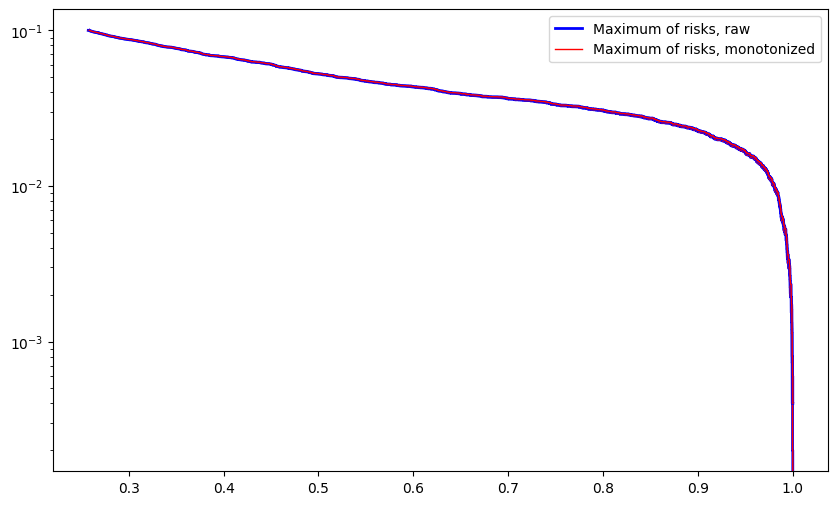

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(
    conf.confidence_conformalizer.optimizer2_minus.all_lbds,
    conf.confidence_conformalizer.optimizer2_minus.all_risks_raw,
    c="b",
    linewidth=2,
)
plt.plot(
    conf.confidence_conformalizer.optimizer2_minus.all_lbds,
    conf.confidence_conformalizer.optimizer2_minus.all_risks_mon,
    c="r",
    linewidth=1,
)

plt.plot(
    conf.confidence_conformalizer.optimizer2_plus.all_lbds,
    conf.confidence_conformalizer.optimizer2_plus.all_risks_raw,
    c="b",
    linewidth=2,
    label="Maximum of risks, raw",
)
plt.plot(
    conf.confidence_conformalizer.optimizer2_plus.all_lbds,
    conf.confidence_conformalizer.optimizer2_plus.all_risks_mon,
    c="r",
    linewidth=1,
    label="Maximum of risks, monotonized",
)

plt.yscale("log")
plt.legend()

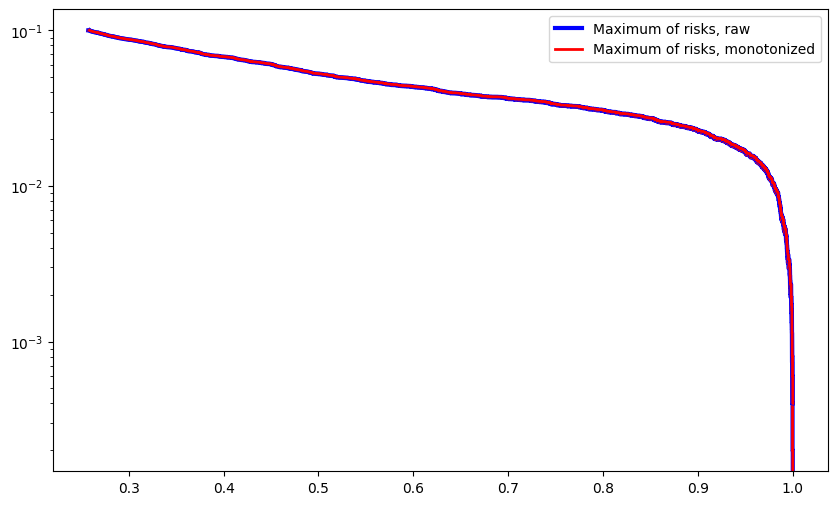

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(
    conf.confidence_conformalizer.optimizer2_minus.all_lbds,
    conf.confidence_conformalizer.optimizer2_minus.all_risks_raw_conf,
    c="b",
    linewidth=3,
)
plt.plot(
    conf.confidence_conformalizer.optimizer2_minus.all_lbds,
    conf.confidence_conformalizer.optimizer2_minus.all_risks_mon_conf,
    c="r",
    linewidth=2,
)

plt.plot(
    conf.confidence_conformalizer.optimizer2_plus.all_lbds,
    conf.confidence_conformalizer.optimizer2_plus.all_risks_raw_conf,
    c="b",
    linewidth=3,
    label="Maximum of risks, raw",
)
plt.plot(
    conf.confidence_conformalizer.optimizer2_plus.all_lbds,
    conf.confidence_conformalizer.optimizer2_plus.all_risks_mon_conf,
    c="r",
    linewidth=2,
    label="Maximum of risks, monotonized",
)

plt.yscale("log")
plt.legend()

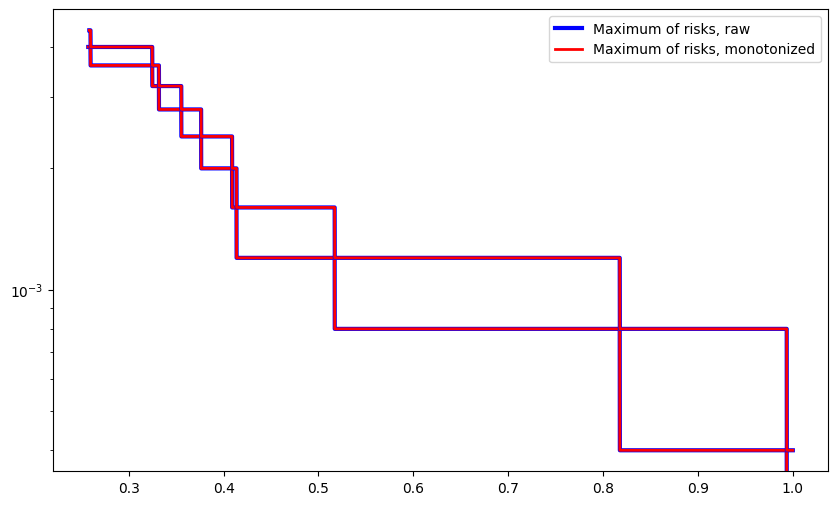

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(
    conf.confidence_conformalizer.optimizer2_minus.all_lbds,
    conf.confidence_conformalizer.optimizer2_minus.all_risks_raw_loc,
    c="b",
    linewidth=3,
)
plt.plot(
    conf.confidence_conformalizer.optimizer2_minus.all_lbds,
    conf.confidence_conformalizer.optimizer2_minus.all_risks_mon_loc,
    c="r",
    linewidth=2,
)

plt.plot(
    conf.confidence_conformalizer.optimizer2_plus.all_lbds,
    conf.confidence_conformalizer.optimizer2_plus.all_risks_raw_loc,
    c="b",
    linewidth=3,
    label="Maximum of risks, raw",
)
plt.plot(
    conf.confidence_conformalizer.optimizer2_plus.all_lbds,
    conf.confidence_conformalizer.optimizer2_plus.all_risks_mon_loc,
    c="r",
    linewidth=2,
    label="Maximum of risks, monotonized",
)

plt.yscale("log")
plt.legend()

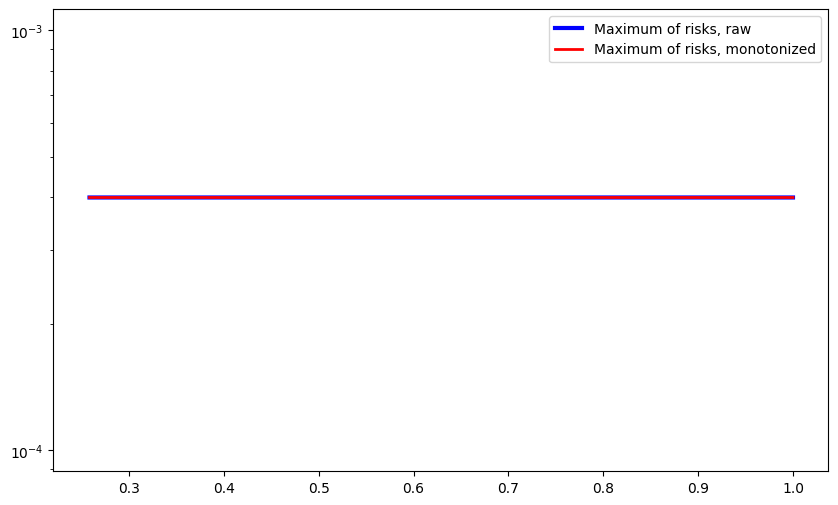

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(
    conf.confidence_conformalizer.optimizer2_minus.all_lbds,
    conf.confidence_conformalizer.optimizer2_minus.all_risks_raw_cls,
    c="b",
    linewidth=3,
)
plt.plot(
    conf.confidence_conformalizer.optimizer2_minus.all_lbds,
    conf.confidence_conformalizer.optimizer2_minus.all_risks_mon_cls,
    c="r",
    linewidth=2,
)

plt.plot(
    conf.confidence_conformalizer.optimizer2_plus.all_lbds,
    conf.confidence_conformalizer.optimizer2_plus.all_risks_raw_cls,
    c="b",
    linewidth=3,
    label="Maximum of risks, raw",
)
plt.plot(
    conf.confidence_conformalizer.optimizer2_plus.all_lbds,
    conf.confidence_conformalizer.optimizer2_plus.all_risks_mon_cls,
    c="r",
    linewidth=2,
    label="Maximum of risks, monotonized",
)

plt.yscale("log")
plt.legend()

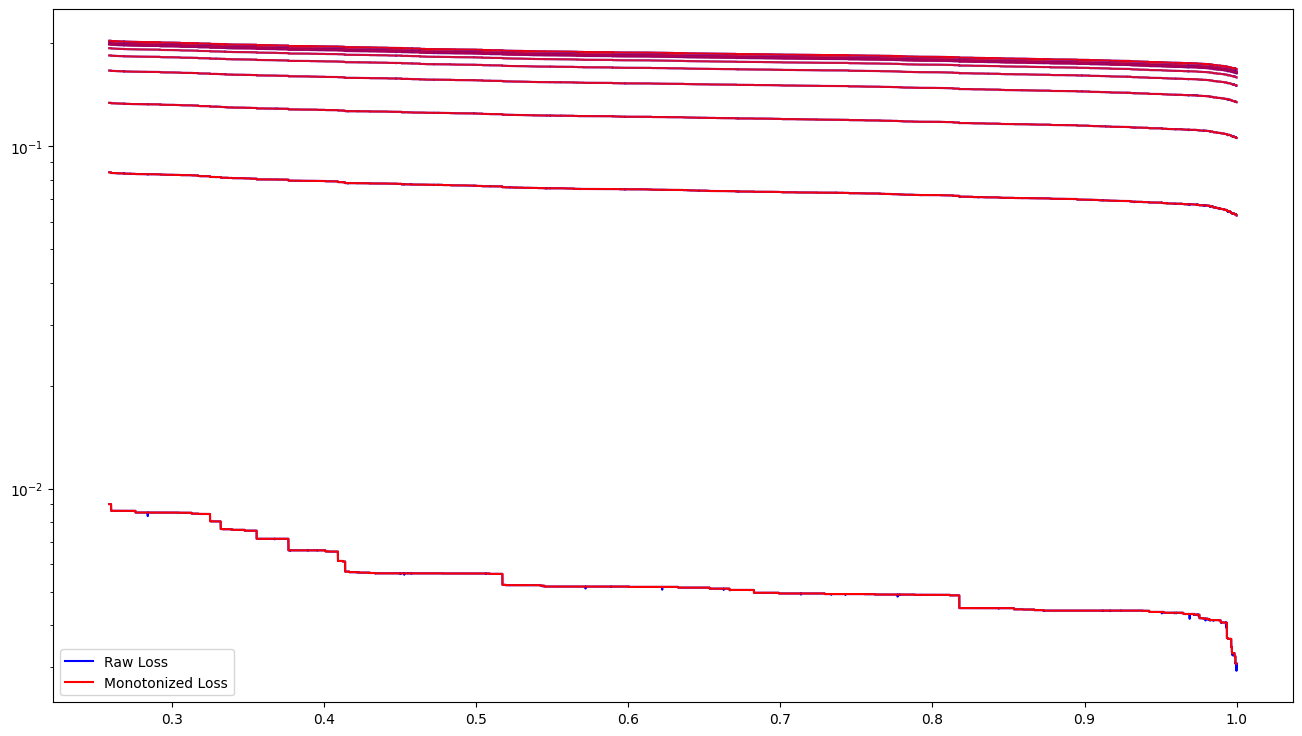

In [9]:
plt.figure(figsize=(16, 9))
n = len(conf.localization_conformalizer.optimizer2.all_risks_raw) / 13
n = int(n)
for i in range(13):
    # if i!=4:
    #    continue
    plt.plot(
        conf.localization_conformalizer.optimizer2.all_lbds_cnf[
            i * n : (i + 1) * n
        ],
        conf.localization_conformalizer.optimizer2.all_risks_raw[
            i * n : (i + 1) * n
        ],
        c="b",
        alpha=1 - 0.5 * i / 13,
        label="Raw Loss" if i == 0 else None,
    )
    plt.plot(
        conf.localization_conformalizer.optimizer2.all_lbds_cnf[
            i * n : (i + 1) * n
        ],
        conf.localization_conformalizer.optimizer2.all_risks_mon[
            i * n : (i + 1) * n
        ],
        c="r",
        alpha=1 - 0.5 * i / 13,
        label="Monotonized Loss" if i == 0 else None,
    )
plt.yscale("log")
plt.legend()

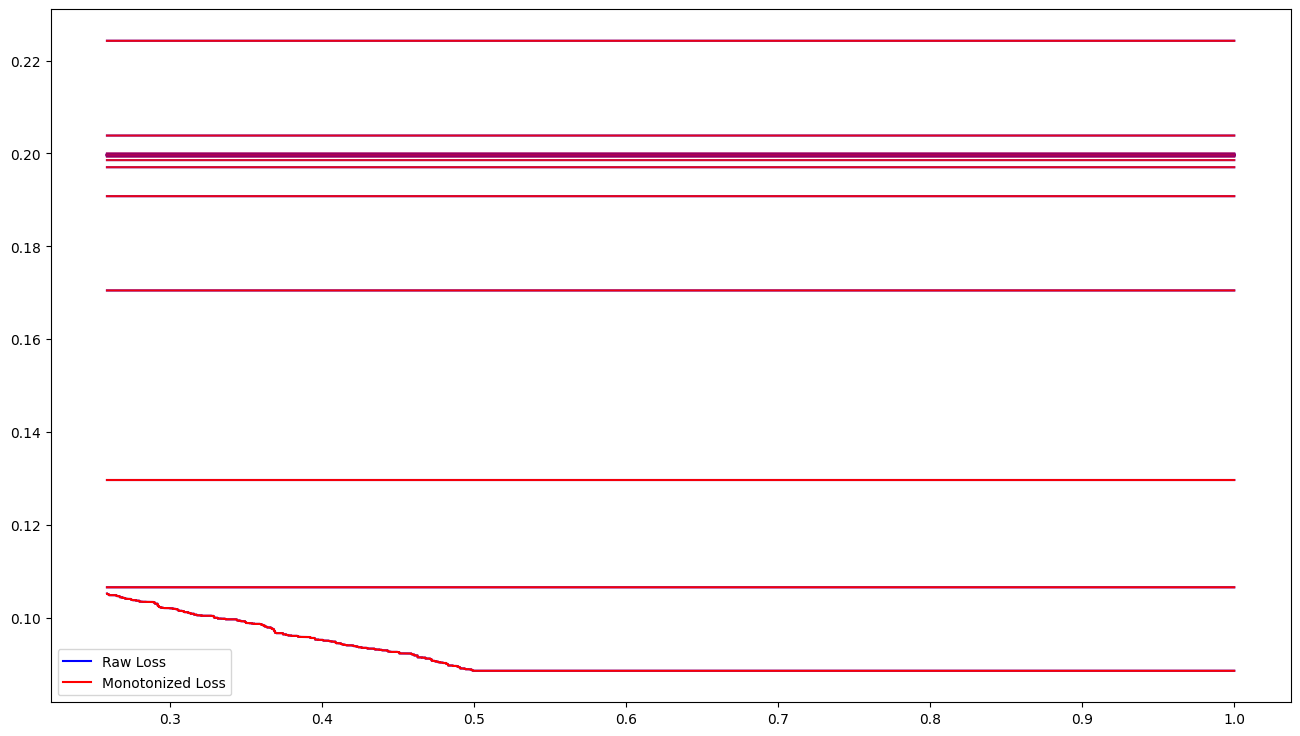

In [10]:
plt.figure(figsize=(16, 9))
n = len(conf.classification_conformalizer.optimizer2.all_risks_raw) // 25
for i in range(25):
    # if i!=24:
    #    continue
    plt.plot(
        conf.classification_conformalizer.optimizer2.all_lbds_cnf[
            i * n : (i + 1) * n
        ],
        conf.classification_conformalizer.optimizer2.all_risks_raw[
            i * n : (i + 1) * n
        ],
        c="b",
        alpha=1 - 0.5 * i / 25,
        label="Raw Loss" if i == 0 else None,
    )
    plt.plot(
        conf.classification_conformalizer.optimizer2.all_lbds_cnf[
            i * n : (i + 1) * n
        ],
        conf.classification_conformalizer.optimizer2.all_risks_mon[
            i * n : (i + 1) * n
        ],
        c="r",
        alpha=1 - 0.5 * i / 25,
        label="Monotonized Loss" if i == 0 else None,
    )
plt.legend()

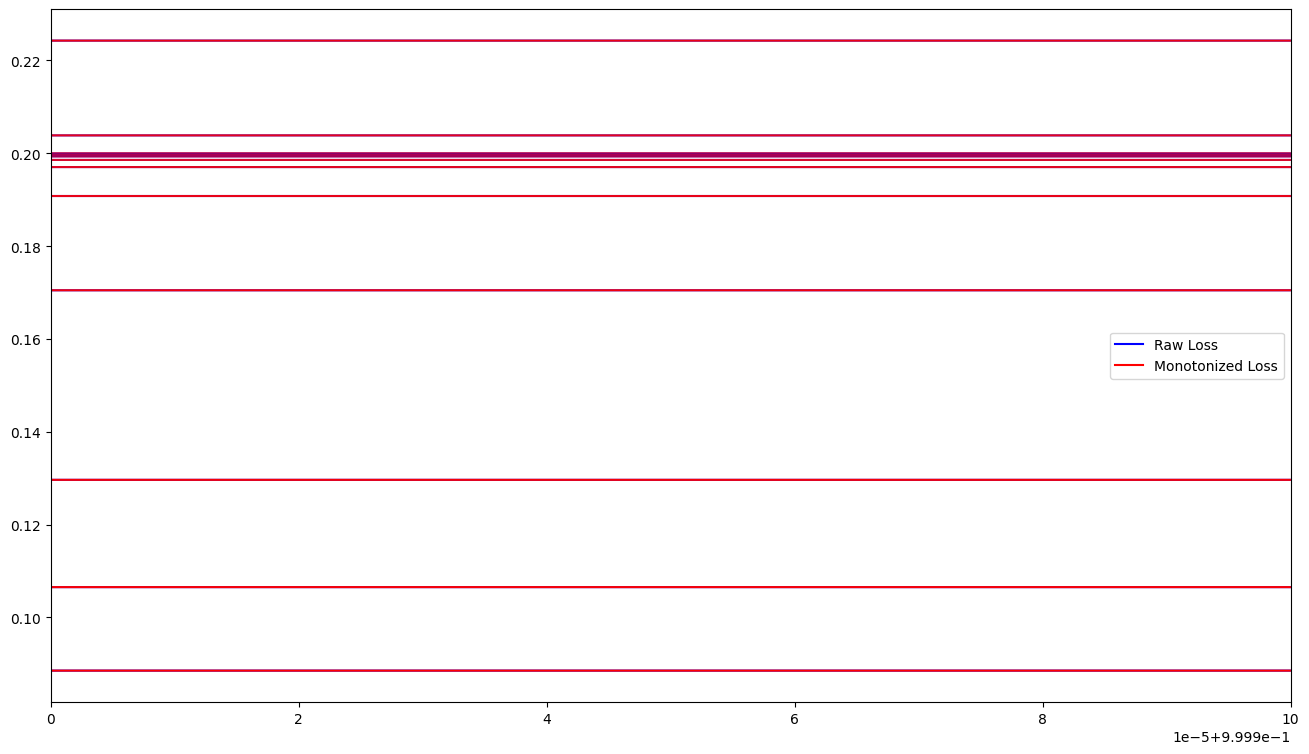

In [11]:
plt.figure(figsize=(16, 9))
n = len(conf.classification_conformalizer.optimizer2.all_risks_raw) // 25
for i in range(25):
    plt.plot(
        conf.classification_conformalizer.optimizer2.all_lbds_cnf[
            i * n : (i + 1) * n
        ],
        conf.classification_conformalizer.optimizer2.all_risks_raw[
            i * n : (i + 1) * n
        ],
        c="b",
        alpha=1 - 0.5 * i / 25,
        label="Raw Loss" if i == 0 else None,
    )
    plt.plot(
        conf.classification_conformalizer.optimizer2.all_lbds_cnf[
            i * n : (i + 1) * n
        ],
        conf.classification_conformalizer.optimizer2.all_risks_mon[
            i * n : (i + 1) * n
        ],
        c="r",
        alpha=1 - 0.5 * i / 25,
        label="Monotonized Loss" if i == 0 else None,
    )
plt.xlim(0.9999, 1)
plt.legend()

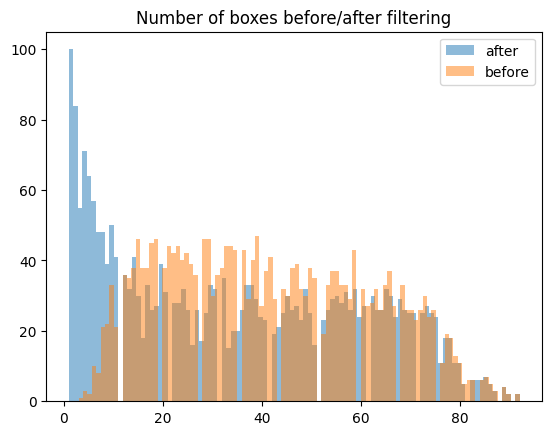

In [12]:
from cods.od.models.utils import bayesod, filter_preds

before = [len(x) for x in preds_val.pred_boxes]
pp = filter_preds(preds_val, confidence_threshold=1e-3)
after = [len(x) for x in pp.pred_boxes]
plt.hist(after, bins=100, alpha=0.5, label="after")
plt.hist(before, bins=100, alpha=0.5, label="before")
plt.title("Number of boxes before/after filtering")
plt.legend()

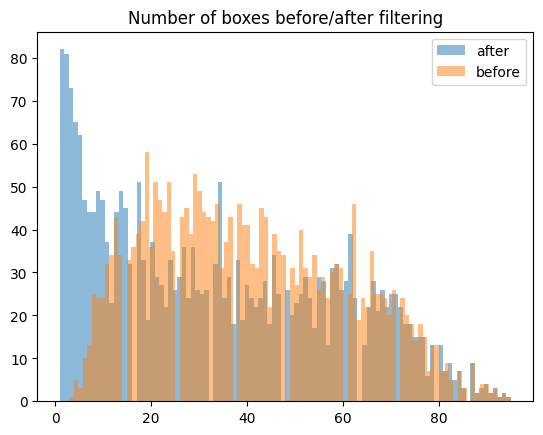

In [13]:
from cods.od.models.utils import bayesod, filter_preds

before = [len(x) for x in preds_cal.pred_boxes]
pp = filter_preds(preds_cal, confidence_threshold=1e-3)
after = [len(x) for x in pp.pred_boxes]
plt.hist(after, bins=100, alpha=0.5, label="after")
plt.hist(before, bins=100, alpha=0.5, label="before")
plt.title("Number of boxes before/after filtering")
plt.legend()